In [2]:
import os
import csv
import numpy as np
import pandas as pd
import pylab as p
from statsmodels.graphics.mosaicplot import mosaic
os.chdir('/Users/jentsai/Desktop/Musica/other/kaggle/titanic/')


In [6]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

train['type'] = 'train'
test['type'] = 'test'
# Concatenate train and test for table manipulation
full = pd.concat([train,test])
features = list(full)
full.dtypes

# missing values?
full.info()
full.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
type           1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


//anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,328.000000,2.000000,0.000000,NaN
50%,NaN,NaN,0.000000,655.000000,3.000000,0.000000,NaN
75%,NaN,NaN,0.000000,982.000000,3.000000,1.000000,NaN
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


          Pclass        Age   Survived
count  22.000000  22.000000  22.000000
mean    1.590909  66.022727   0.227273
std     0.854071   5.024884   0.428932
min     1.000000  61.000000   0.000000
25%     1.000000  62.000000   0.000000
50%     1.000000  64.500000   0.000000
75%     2.000000  70.000000   0.000000
max     3.000000  80.000000   1.000000
Sex     Survived
female  1.0          3
male    0.0         17
        1.0          2
dtype: int64


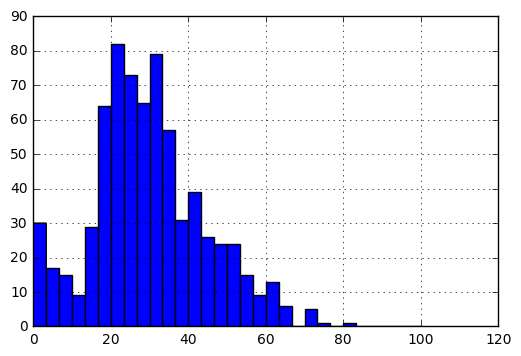

In [10]:
# how older passengers fare?
print(full[(full['Age'] > 60) & (full['type'] =='train')][['Sex', 'Pclass', 'Age', 'Survived']].describe())
print(full[(full['Age'] > 60) & (full['type'] =='train')].groupby(["Sex", "Survived"]).size())

full['Age'][full['type'] =='train'].dropna().hist(bins=30,range=(0,100))
p.show()

# Transformations

### Sex

In [12]:
full['SexF'] = full['Sex'].map({'female':0,'male':1}).astype(int)

### Titles

#### Might be able to use title to derive the origin of the passenger?

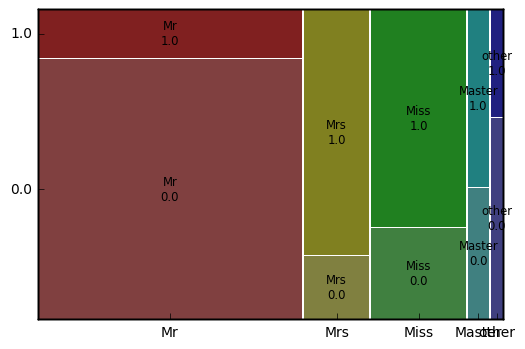

In [18]:
# Get title
full['Title'] = full['Name'].map(lambda x: x.split(',')[-1].split('.')[0].strip())
full['TitleF'] = full['Title'].map({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
full.loc[full['TitleF'].isnull(),'TitleF'] = full['Title'][full['TitleF'].isnull()]
# group titles for low counts
other_titles = full['TitleF'][full['type'] =='train'].value_counts()[full['TitleF'][full['type'] =='train'].value_counts()<10].index.tolist()
full['TitleF'].replace(other_titles, 'other', inplace=True)
mosaic(full[full.type=='train'], ['TitleF', 'Survived'])
p.show()

### Family Size

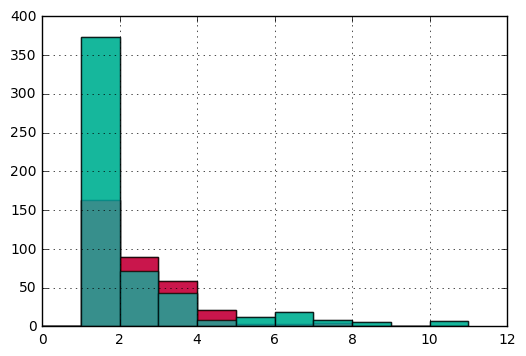

In [24]:
full['FamilySize'] = full['SibSp'] + full['Parch'] + 1
full[(full['Survived']==1)&(full['type'] =='train')]['FamilySize'].dropna().hist(alpha=0.7,bins=range(12))
full[(full['Survived']==0)&(full['type'] =='train')]['FamilySize'].dropna().hist(alpha=0.7,bins=range(12))
p.show()

#### more survived in family sizes 2-4

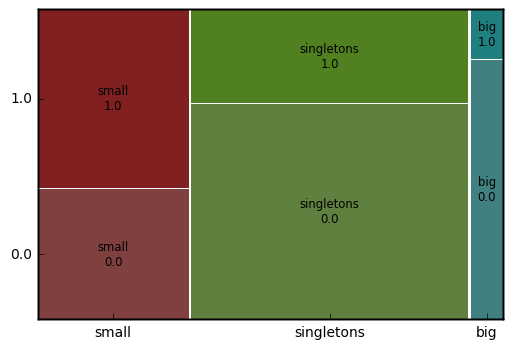

In [25]:
# Group family by size
full['FamilySizeF'] = 'small'
full.loc[full['FamilySize'] == 1,'FamilySizeF'] = 'singletons'
full.loc[full['FamilySize'] >= 5,'FamilySizeF'] = 'big'
mosaic(full[full.type=='train'], ['FamilySizeF', 'Survived'])
p.show()

## Embarked

      Age Cabin Embarked  Fare                                       Name  \
61   38.0   B28      NaN  80.0                        Icard, Miss. Amelie   
829  62.0   B28      NaN  80.0  Stone, Mrs. George Nelson (Martha Evelyn)   

     Parch  PassengerId  Pclass     Sex  SibSp  Survived  Ticket   type  SexF  \
61       0           62       1  female      0       1.0  113572  train     0   
829      0          830       1  female      0       1.0  113572  train     0   

    Title TitleF  FamilySize FamilySizeF  
61   Miss   Miss           1  singletons  
829   Mrs    Mrs           1  singletons  


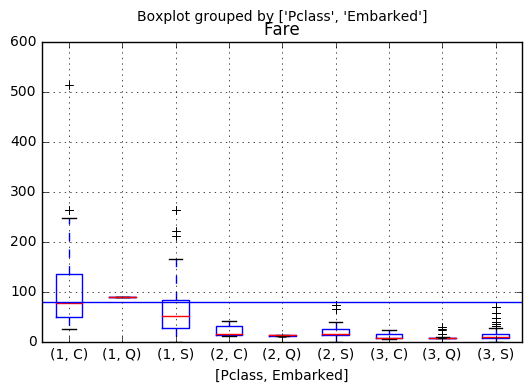

In [32]:
# Fill in the missing values
print(full[full['Embarked'].isnull()]) # Fares are 80 and Survived and Pclass are 1 only missing value is in train
full[full['Embarked'].notnull()][['Embarked','Fare','Pclass']].boxplot(by=['Pclass','Embarked'])
p.axhline(y=80)
p.show()


In [35]:
# Median Fare at Pclass 1 and Embarked C is also 80
# Let missing Embarked to be C
full.loc[full['Embarked'].isnull(),'Embarked'] = 'C'

## Age

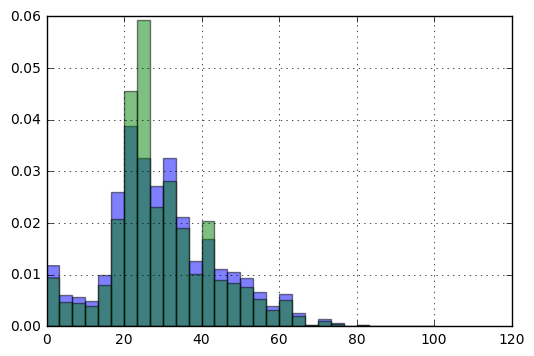

In [36]:
# Impute missing Age values
median_ages_train = np.zeros((2,3))
median_ages_test = np.zeros((2,3))

for i in range(0, 2):
    for j in range(0, 3):
        median_ages_train[i, j] = full[(full['SexF'] == i) & \
                               (full['Pclass'] == j + 1)&(full['type'] =='train')]['Age'].dropna().median()

for i in range(0, 2):
    for j in range(0, 3):
        median_ages_test[i, j] = full[(full['SexF'] == i) & \
                               (full['Pclass'] == j + 1)&(full['type'] =='test')]['Age'].dropna().median()

full['AgeF'] = full['Age']

for i in range(0, 2):
    for j in range(0, 3):
        full.loc[ (full.Age.isnull()) & (full.SexF == i) & (full.Pclass == j+1) & (full.type=='train'),\
                'AgeF'] = median_ages_train[i,j]

for i in range(0, 2):
    for j in range(0, 3):
        full.loc[ (full.Age.isnull()) & (full.SexF == i) & (full.Pclass == j+1) & (full.type=='test'),\
                'AgeF'] = median_ages_test[i,j]

full['Age'].dropna().hist(bins=30,range=(0,100),normed=True,alpha=0.5)
full['AgeF'].dropna().hist(bins=30,range=(0,100),normed=True,alpha=0.5)
p.show()

## Fare

In [38]:
# Missing Fare in test dataset
full.loc[(full.type=='test')&(full.Fare.isnull()),'Fare'] = full['Fare'][(full.Pclass==3)&(full.Embarked=='S')].median()

## Make features

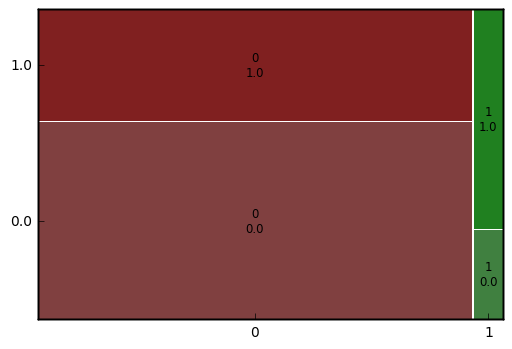

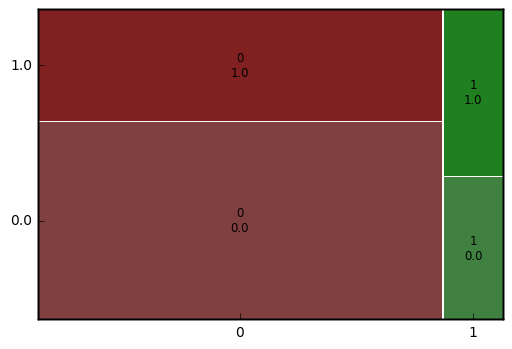

In [42]:
full['Mother'] = 0
full.loc[(full['Sex'] == 'female') & (full['Parch'] > 0) & (full['AgeF'] > 18) & (full['Title'] != 'Miss'),'Mother'] = 1

full['Child'] = 1
full.loc[full['AgeF'] >= 18,'Child'] = 0

mosaic(full[full.type=='train'], ['Mother', 'Survived'])
mosaic(full[full.type=='train'], ['Child', 'Survived'])
p.show()

## Model fitting

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
label_pr = preprocessing.LabelEncoder()
full['EmbarkedF'] = label_pr.fit_transform(full.Embarked)
full.TitleF = label_pr.fit_transform(full.TitleF)
full.FamilySizeF = label_pr.fit_transform(full.FamilySizeF)
forest = RandomForestClassifier(n_estimators = 100)

train = full[full.type=='train']
test = full[full.type=='test']

predictors = ['Pclass','AgeF','SibSp','SexF','Parch','Fare','EmbarkedF','TitleF','FamilySizeF','Child','Mother']
forest = forest.fit(train[predictors],train['Survived'])
output = forest.predict(test[predictors])

#forest.score(train[['Pclass','AgeF','SibSp','Parch','Fare','EmbarkedF','TitleF','FamilySizeF','Child','Mother']],train['Survived'])
test.Survived = output.astype(int)
test[['PassengerId','Survived']].to_csv('survival.csv',header=True,index=False)
np.savetxt('survival.csv',output)
forest.score(train[predictors],train['Survived'])


//anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0.98316498316498313

In [74]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cross_validation import KFold
from sklearn import cross_validation
kf = KFold(train.shape[0], n_folds=3, random_state=1)
scores = cross_validation.cross_val_score(forest, train[predictors], train["Survived"], cv=kf)
print(scores.mean())

0.800224466891


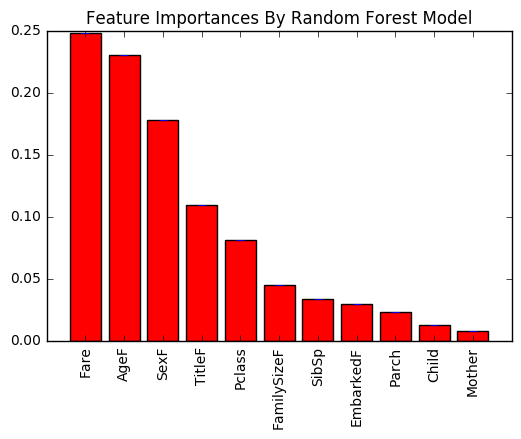

In [75]:
importances=forest.feature_importances_
std = np.std([forest.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])

p.figure()
p.title("Feature Importances By Random Forest Model")
p.bar(range(np.size(predictors)), importances[indices],
       color="r", yerr=std[indices], align="center")
p.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

p.xlim([-1, np.size(predictors)])
p.show()

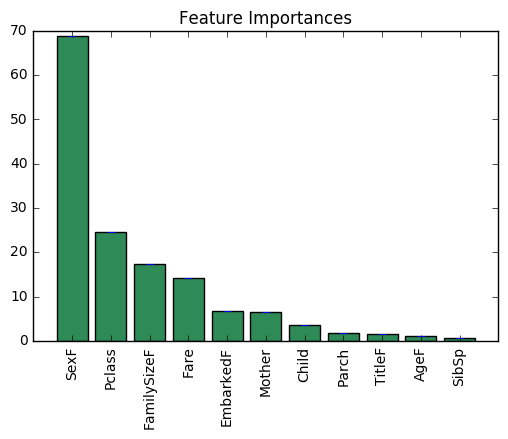

In [76]:
selector = SelectKBest(f_classif, k=5)
selector.fit(train[predictors], train["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

indices = np.argsort(scores)[::-1]

sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
p.figure()
p.title("Feature Importances")
p.bar(range(np.size(predictors)), scores[indices],
       color="seagreen", yerr=std[indices], align="center")
p.xticks(range(np.size(predictors)), sorted_important_features, rotation='vertical')

p.xlim([-1, np.size(predictors)])
p.show()


In [83]:
# Pick only the five best features.
predictors = ["Pclass", "SexF", "Fare", "TitleF","AgeF"]

alg = RandomForestClassifier(random_state=1, n_estimators=50, max_depth=8,min_samples_split=6, min_samples_leaf=4)

#alg = RandomForestClassifier(random_state=1, n_estimators=50, min_samples_split=8, min_samples_leaf=4)
kf = KFold(train.shape[0], n_folds=3, random_state=1)

scores = cross_validation.cross_val_score(alg, train[predictors], train["Survived"], cv=kf)
# Take the mean of the scores 
print(scores.mean())

0.837261503928


In [84]:
    # Fit the algorithm using the full training data.
alg.fit(train[predictors], train["Survived"])
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
predictions = alg.predict(test[predictors])

predictions=predictions.astype(int)
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("survived2.csv", index=False)